In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

import seaborn as sns

from SGanalysis.SGobject import SGobject

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text


# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'
tools_path = '../helperScripts/tools.py'
# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [4]:
roi_of_interest= 'dish_roi2'

# load the sg_object
with open(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

In [5]:

# load the dataframes with the cell by gene matrices, clustered and unclustered
unclustered_df =  pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.2thresh.csv')

In [6]:
# merge the clustered and unclustered dataframes
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [7]:
df['cell_id'] = [str(id) for id in df['object_id']]

# sg_obj.gdf['cell_id'] = [str(x) for x in sg_obj.gdf['object_id']]
sg_obj.gdf['object_id'] = sg_obj.gdf.index
sg_obj.gdf['cell_id'] = sg_obj.gdf['object_id'].astype('string')
sg_obj.gdf.index.name = 'index'
sg_obj.gdf = sg_obj.gdf.sort_values('object_id')

# assign clusters to the sg_obj
sg_obj.gdf = sg_obj.gdf.merge(df[['cell_id']+list(df.columns.difference(sg_obj.gdf.columns))],on=['cell_id'],how='left')

In [8]:
sister_cells = {}
for bc_set in np.unique(df[df['n_called_barcodes']>4]['barcode_names'].values):
    if len(df[df['barcode_names']==bc_set]) > 3:

        sister_cells[bc_set] = df[df['barcode_names']==bc_set].index

In [9]:
adata_genes = sc.AnnData(df[[col for col in tools.gene_cols if col in df.columns]])

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_76875/4178882684.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes = sc.AnnData(df[[col for col in tools.gene_cols if col in df.columns]])
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
df[[col for col in tools.gene_cols if col in df.columns]]

,IGFBP2,IGFBP7,CAPG,SNAI2,VGF,MMP1,ITGA3,SERPINE1,COL1A1,CCND1,...,SOX9,ROR2,SLIT2,BMP4,FOSB,KIT,NOTCH4,DKK3,SOX2,NANOG
0,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0.0,13.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.0,0.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13.0,0.0,23.0,10.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16371,4.0,0.0,13.0,5.0,0.0,0.0,1.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16372,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16373,6.0,0.0,17.0,5.0,0.0,0.0,1.0,0.0,0.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16374,8.0,0.0,13.0,12.0,0.0,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
adata_genes

AnnData object with n_obs × n_vars = 16376 × 117

In [12]:
adata_genes

AnnData object with n_obs × n_vars = 16376 × 117

In [13]:
# log(x+1) transform the data
sc.pp.log1p(adata_genes)

In [14]:
adata_genes

AnnData object with n_obs × n_vars = 16376 × 117
    uns: 'log1p'

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


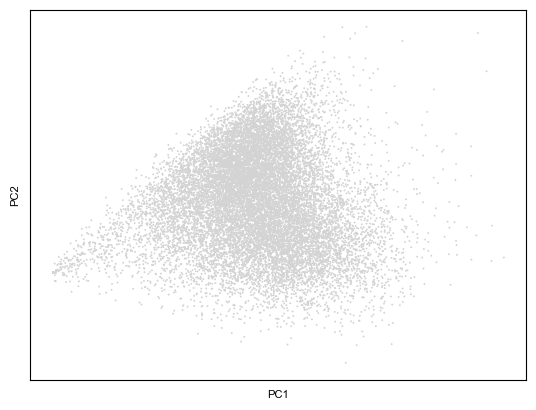

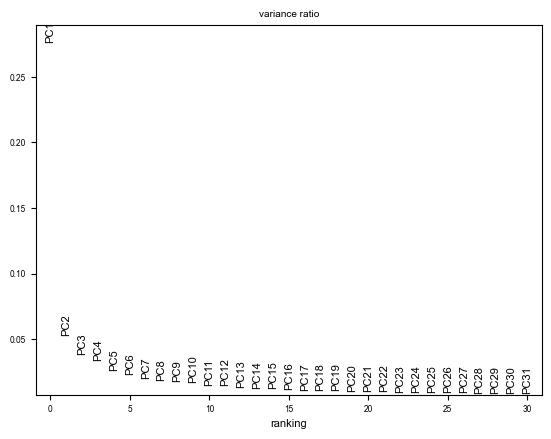

In [15]:
sc.pp.pca(adata_genes)
sc.pl.pca(adata_genes)
sc.pl.pca_variance_ratio(adata_genes, log=False)

In [16]:
sc.pp.neighbors(adata_genes)

In [17]:
# sc.pp.scale(adata_genes)
sc.tl.umap(adata_genes)
sc.tl.leiden(adata_genes, n_iterations=-1)

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


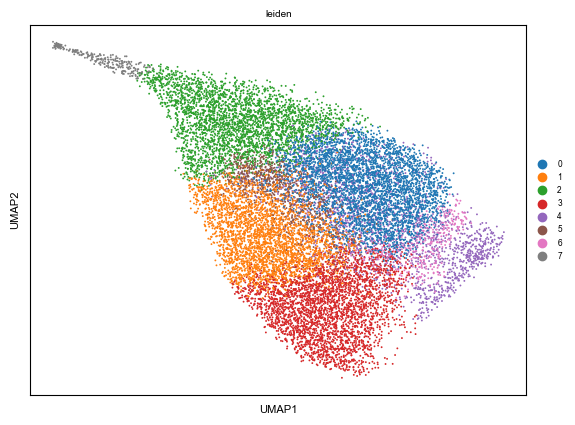

In [18]:
sc.pl.umap(adata_genes, color=["leiden"])

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


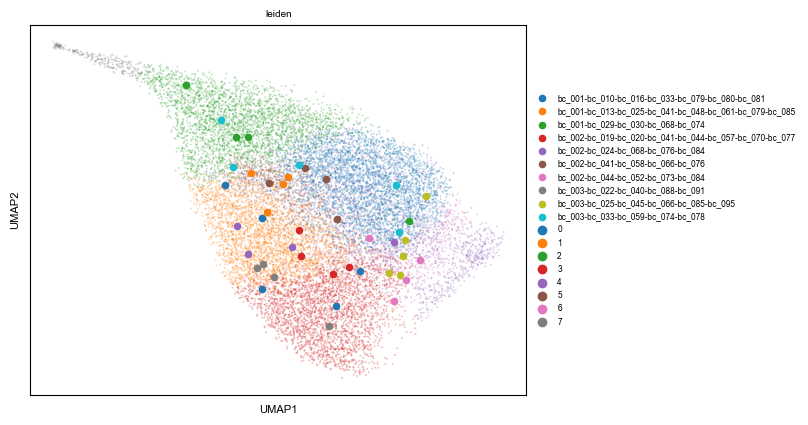

In [19]:
fig,ax = plt.subplots()
for b,(bc_set,ix) in enumerate(sister_cells.items()):
    if b < 10:
        umap_coords = adata_genes[ix].obsm['X_umap']
        ax.scatter(umap_coords[:,0],umap_coords[:,1],s=20,zorder=10,label=bc_set) 
sc.pl.umap(adata_genes, color=["leiden"],ax=ax,alpha=0.3)

 

In [20]:
# cells do appear to be closer in the umap, but let's also adjust for cell cycle:
cell_cycle_genes = tools.regev_cell_cycle_genes
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_genes.var_names]

In [21]:
sc.tl.score_genes(adata_genes,cell_cycle_genes,score_name='g2m_score')

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


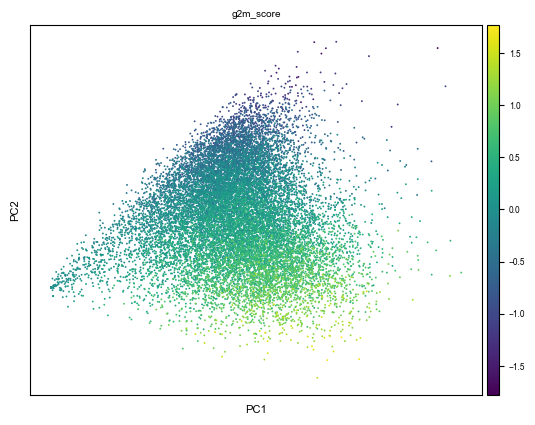

In [22]:
sc.pl.pca(adata_genes,color='g2m_score')

In [23]:
sc.pp.regress_out(adata_genes, ['g2m_score'])
sc.pp.scale(adata_genes)

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


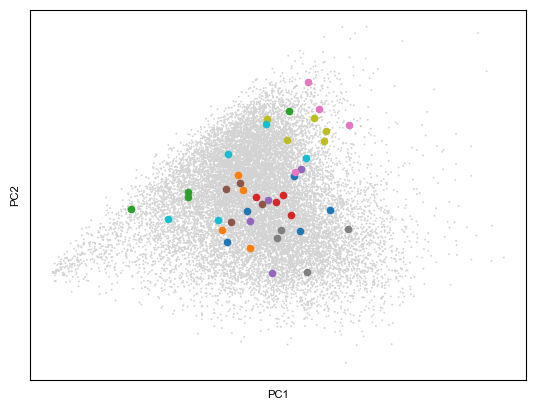

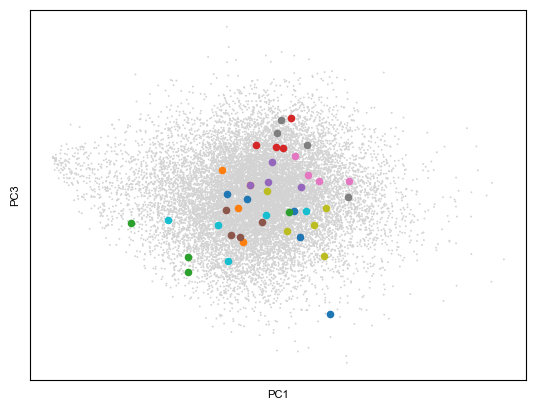

In [24]:
fig,ax = plt.subplots()
for b,(bc_set,ix) in enumerate(sister_cells.items()):
    if b < 10:
        pca_coords = adata_genes[ix].obsm['X_pca']
        ax.scatter(pca_coords[:,0],pca_coords[:,1],s=20,zorder=10,label=bc_set) 

sc.pl.pca(adata_genes,ax=ax,components='1,2')

fig,ax = plt.subplots()
for b,(bc_set,ix) in enumerate(sister_cells.items()):
    if b < 10:
        pca_coords = adata_genes[ix].obsm['X_pca']
        ax.scatter(pca_coords[:,0],pca_coords[:,2],s=20,zorder=10,label=bc_set) 

sc.pl.pca(adata_genes,ax=ax,components='1,3')
# ax.legend()
# fig.savefig('pca_sister_cells_G2Mregressed.pdf',bbox_inches='tight')
# fig.savefig('pca_sister_cells_G2Mregressed.png',dpi=300,bbox_inches='tight')

In [25]:
sister_cells_more = {}
for bc_set in np.unique(df[df['n_called_barcodes']>3]['barcode_names'].values):
    if len(df[df['barcode_names']==bc_set]) > 1:

        sister_cells_more[bc_set] = df[df['barcode_names']==bc_set]['object_id'].values


sisterhood_by_cell_ix = {i:bc_set for bc_set,ix in sister_cells_more.items() for i in ix}
sister_ids_by_cell_ix = {i:list(sister_cells_more[bc_set]) for bc_set,ix in sister_cells_more.items() for i in ix}

In [26]:
# calculate the distance matrix of cells
centroid_array = np.stack(sg_obj.gdf['nucleus_centroid'].apply(lambda x: np.array(x.coords).ravel()))

distance_matrix = scipy.spatial.distance.pdist(centroid_array)
square_distance_matrix =scipy.spatial.distance.squareform(distance_matrix)

In [27]:
# get neighbors of a focal cell
def find_neighbors(ix,distance_matrix,threshold):
    # ix = df.index
    # this_ix = np.where(df['cell_id'] == cell_id)[0][0]

    # print(this_ix)
    neighbor_ix  = np.where(distance_matrix[ix,:] < threshold)[0]
    neighbor_ix = neighbor_ix[neighbor_ix != ix]    

    # neighbors = [x for x in df['cell_id'].values[neighbor_ix] if x !=cell_id]
     
    return neighbor_ix

# get non-sister neighbors of a focal cell
def find_non_sister_neighbors(ix,sisters,distance_matrix,threshold):
    neighbors = find_neighbors(ix,distance_matrix,threshold)
    non_sister_neighbors = [x for x in neighbors if x not in sisters]
    return non_sister_neighbors

# access by cell id
def find_neighbors_by_cell_id(cell_id,df,distance_matrix,threshold):
    # ix = df.index
    this_ix = np.where(df['cell_id'] == cell_id)[0][0]

    # print(this_ix)
    neighbor_ix  = np.where(distance_matrix[this_ix,:] < threshold)[0]

    neighbors = [x for x in df['cell_id'].values[neighbor_ix] if x!=cell_id]
     
    return neighbors




In [28]:
sister_more_dists = []
randos = []
neighbors= []
non_sister_neighbors = []

neighbor_distance = 3000

# all_ids = df.index
# all_ids = range(len(df))
all_ids = range(len(adata_genes))

pcs_to_use = 10

for b,(bc_set,ix) in enumerate(sister_cells_more.items()):

    # get the ix of the sister cells
    ix = np.where(df['object_id'].isin(list(ix)))[0]

    pca_coords = adata_genes[list(ix)].obsm['X_pca']

    d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # calculate distance using top 20 PCs
    sister_more_dists.append(np.mean(d))

    pca_coords = adata_genes[np.random.choice(all_ids,len(ix))].obsm['X_pca']
    d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # calculate distance using top 20 PCs
    randos.append(np.mean(d))

    random_cell = np.random.choice(all_ids,1)[0]
    these_neighbors = find_neighbors(random_cell,square_distance_matrix,neighbor_distance)
    pca_coords = adata_genes[np.random.choice(these_neighbors,len(ix))].obsm['X_pca']
    d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # calculate distance using top 20 PCs
    neighbors.append(np.mean(d))

    # print('3')




Text(0.5, 0, 'Mean distance between sisters')

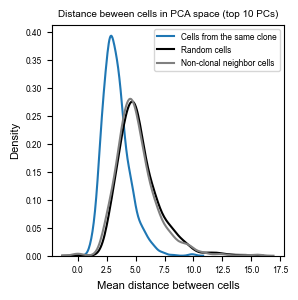

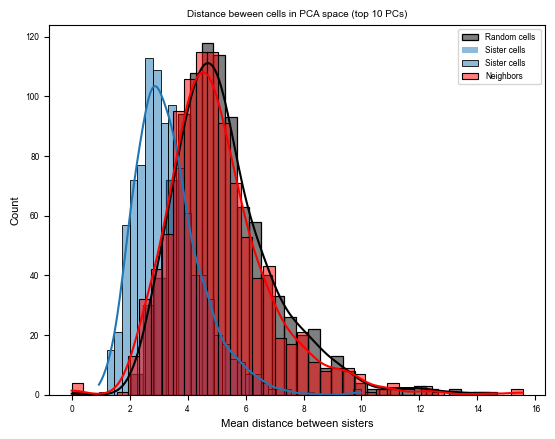

In [29]:
fig,ax = plt.subplots(figsize=(3,3))
sns.kdeplot(sister_more_dists,ax=ax,alpha=1.0,label='Cells from the same clone')
sns.kdeplot(randos,ax=ax,color='k',alpha=1.0,label='Random cells')
sns.kdeplot(neighbors,ax=ax,color='gray',alpha=1.0,label='Non-clonal neighbor cells')
# sns.histplot(neighbors,ax=ax,color='r',kde=True,alpha=0.5,label='Neighbors')
# sns.kdeplot(randos,ax=ax,color='gray',alpha=0.5)
# sns.kdeplot(sister_more_dists,ax=ax,alpha=0.5)
plt.legend()
plt.title(f'Distance beween cells in PCA space (top {pcs_to_use} PCs)')
plt.xlabel('Mean distance between cells')
plt.savefig(f'../graphs/sister_cell_distances_withrandom_{pcs_to_use}PCs.pdf',bbox_inches='tight')

fig,ax = plt.subplots()
sns.histplot(randos,ax=ax,color='k',kde=True,alpha=0.5,label='Random cells ')
sns.histplot(sister_more_dists,ax=ax,kde=True,alpha=0.5,label='Sister cells')
sns.histplot(neighbors,ax=ax,color='r',kde=True,alpha=0.5,label='Neighbors')
# sns.kdeplot(randos,ax=ax,color='gray',alpha=0.5)
# sns.kdeplot(sister_more_dists,ax=ax,alpha=0.5)
plt.legend()
plt.title(f'Distance beween cells in PCA space (top {pcs_to_use} PCs)')
plt.xlabel('Mean distance between sisters')
# plt.savefig(f'sister_cell_distances_withrandom_{pcs_to_use}PCs.pdf',bbox_inches='tight')



In [30]:
print('T-test for difference in means between random and sister cells:')
print(scipy.stats.ttest_ind(randos,sister_more_dists))
print('')
print('T-test for difference in means between neighbor and sister cells:')
print(scipy.stats.ttest_ind(neighbors,sister_more_dists))

T-test for difference in means between random and sister cells:
Ttest_indResult(statistic=29.024005993991125, pvalue=1.4180684402956018e-154)

T-test for difference in means between neighbor and sister cells:
Ttest_indResult(statistic=25.7575855183163, pvalue=2.1621642547173852e-126)


In [31]:
sister_more_dists = []
randos = []
neighbors= []
non_sister_neighbors = []

neighbor_distance = 3000

# all_ids = df.index
# all_ids = range(len(df))
all_ids = range(len(adata_genes))

np.random.seed(19104)

genes_to_use = ['IFIT2','OASL']

gene_to_use = 'IFIT2'
gene_to_use = 'OASL'
# gene_to_use = 'SFRP1'

sister_list = []
randos_list = []
neighbors_list = []

for b,(bc_set,ix) in enumerate(sister_cells_more.items()):

    if len(bc_set) > 2:
        ix = np.random.choice(ix,2)

    sister_list.append(df.loc[ix][gene_to_use ].values)

    randos_list.append(df.loc[np.random.choice(all_ids,len(ix))][gene_to_use ].values)

    # neighbors of any random cell
    # random_cell = np.random.choice(all_ids,1)[0]
    # these_neighbors = find_neighbors(random_cell,square_distance_matrix,neighbor_distance)
    # neighbors_list.append(df.loc[np.random.choice(these_neighbors,len(ix))][gene_to_use ].values)

    # actual neighbors of one of the sisters
    these_neighbors = find_neighbors(ix[0],square_distance_matrix,neighbor_distance)
    neighbors_list.append(df.loc[np.random.choice(these_neighbors,len(ix))][gene_to_use ].values)


# # convert into a two by two matrix for each pair of sisters as to whether they are both above the cutoff
# sisters_matrix = np.zeros((2,2))
# randos_matrix = np.zeros((2,2))



In [35]:
cutoff = 1

sister_df = pd.DataFrame()
sister_df['sister_A'] = np.asarray(sister_list)[:,0] > cutoff
sister_df['sister_B'] = np.asarray(sister_list)[:,1] > cutoff

sister_crosstab = pd.crosstab(sister_df['sister_A'],sister_df['sister_B'])
print('Sister')
print(sister_crosstab)
print('Fisher exact test:',scipy.stats.fisher_exact(sister_crosstab),'\n')

randos_df = pd.DataFrame()
randos_df['sister_A'] = np.asarray(randos_list)[:,0] > cutoff
randos_df['sister_B'] = np.asarray(randos_list)[:,1] > cutoff

randos_crosstab = pd.crosstab(randos_df['sister_A'],randos_df['sister_B'])
print('Random')
print(randos_crosstab)
print('Fisher exact test:',scipy.stats.fisher_exact(randos_crosstab),'\n')

neighbors_df = pd.DataFrame()
neighbors_df['sister_A'] = np.asarray(neighbors_list)[:,0] > cutoff
neighbors_df['sister_B'] = np.asarray(neighbors_list)[:,1] > cutoff

neighbors_crosstab = pd.crosstab(neighbors_df['sister_A'],neighbors_df['sister_B'])

print('Neighbors')
print(neighbors_crosstab)
print('Fisher exact test:',scipy.stats.fisher_exact(neighbors_crosstab),'\n')

Sister
sister_B  False  True 
sister_A              
False       979      3
True          5      2
Fisher exact test: (130.53333333333333, 0.00042548766958206487) 

Random
sister_B  False  True 
sister_A              
False       975      4
True         10      0
Fisher exact test: (0.0, 1.0) 

Neighbors
sister_B  False  True 
sister_A              
False       982      6
True          1      0
Fisher exact test: (0.0, 1.0) 



In [36]:
### now let's do the same thing but for all the in vitro rois 

roi_list = ['dish_roi1','dish_roi2','dish_roi3']

cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']

for i,in_vitro_roi in enumerate(roi_list):
    # tools.roi_file_paths[in_vitro_roi] = tools.get_roi_file_paths(in_vitro_roi)

    in_vitro_unclustered_df = pd.read_csv(f'{tools.roi_file_paths[in_vitro_roi]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
    in_vitro_clustered_df = pd.read_csv(f'{tools.roi_file_paths[in_vitro_roi]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')
    # merge the clustered and unclustered dataframes
    if i == 0:
        in_vitro_df = in_vitro_unclustered_df.merge(in_vitro_clustered_df[cols_to_keep],on='object_id',how='left') 
        in_vitro_df['roi'] = in_vitro_roi
    else:
        temp_df =  in_vitro_unclustered_df.merge(in_vitro_clustered_df[cols_to_keep],on='object_id',how='left')
        temp_df['roi'] = in_vitro_roi
        # concatenate the dataframes together
        in_vitro_df = pd.concat([in_vitro_df,temp_df],ignore_index=True)


In [37]:
in_vitro_df

,object_id,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,...,nucleus_dilated,nucleus_centroid,center_x,center_y,area,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names,roi
0,1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,24.0,...,POLYGON ((412.58502856785105 -6.69162863884342...,POINT (484.2985867103928 37.27358475833528),484.298587,37.273585,15039.211479,NaN,NaN,NaN,NaN,dish_roi1
1,10,1.0,0.0,0.0,0.0,0.0,0.0,1.0,19.0,20.0,...,POLYGON ((6537.809741479728 -6.939561130451601...,POINT (6592.36287391669 17.85187773739633),6592.362874,17.851878,6508.865478,2333.0,0.0,[],NaN,dish_roi1
2,100,0.0,0.0,0.0,2.0,0.0,3.0,0.0,17.0,116.0,...,POLYGON ((16229.423373494397 98.33765060398754...,POINT (16250.55447890985 186.00466334116928),16250.554479,186.004663,22482.686608,4347.0,5.0,"['bc_031', 'bc_044', 'bc_046', 'bc_054', 'bc_0...",bc_031-bc_044-bc_046-bc_054-bc_063,dish_roi1
3,1000,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,18.0,...,POLYGON ((12874.038838648617 2358.194193243091...,POINT (12882.929668716624 2415.253764583808),12882.929669,2415.253765,9942.971610,NaN,NaN,NaN,NaN,dish_roi1
4,10000,5.0,0.0,0.0,1.0,9.0,0.0,0.0,10.0,95.0,...,"POLYGON ((676.4400467240802 22745.65512265071,...",POINT (681.6892866020384 22827.8774049217),681.689287,22827.877405,17882.368807,2119.0,2.0,"['bc_084', 'bc_087']",bc_084-bc_087,dish_roi1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45983,9995,7.0,0.0,0.0,0.0,8.0,0.0,0.0,2.0,8.0,...,POLYGON ((27613.57464374964 26229.298574998546...,POINT (27608.66227704907 26289.27616420293),27608.662277,26289.276164,13530.901301,NaN,NaN,NaN,NaN,dish_roi3
45984,9996,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,30.0,...,POLYGON ((6172.636636030018 26231.582580884053...,POINT (6180.485741819615 26308.001255712763),6180.485742,26308.001256,15620.297846,2134.0,6.0,"['bc_039', 'bc_076', 'bc_079', 'bc_085', 'bc_0...",bc_039-bc_076-bc_079-bc_085-bc_088-bc_091,dish_roi3
45985,9997,5.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,19.0,...,POLYGON ((2918.2194192345896 26234.39435735585...,POINT (2918.7387637417705 26299.674838490835),2918.738764,26299.674838,14857.574864,470.0,1.0,['bc_073'],bc_073,dish_roi3
45986,9998,4.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,11.0,...,POLYGON ((15157.574643749636 26236.29857499854...,POINT (15170.180786227062 26304.648711251295),15170.180786,26304.648711,14079.420329,176.0,2.0,"['bc_014', 'bc_035']",bc_014-bc_035,dish_roi3


In [38]:
sister_cells_more_all_rois = {}
for roi in roi_list:
    roi_df = in_vitro_df[in_vitro_df['roi'] == roi]
    for bc_set in np.unique(roi_df[roi_df['bc_cluster_n_bcs']>2]['bc_cluster'].values):
        if len(roi_df[roi_df['bc_cluster']==bc_set]) > 1:
            if f'{roi}_{bc_set}' not in sister_cells_more_all_rois:
                sister_cells_more_all_rois[f'{roi}-{bc_set}'] = []
            sister_cells_more_all_rois[f'{roi}-{bc_set}'].extend(roi_df[roi_df['barcode_names']==bc_set]['object_id'].values)
# for bc_set in np.unique(in_vitro_df[in_vitro_df['n_called_barcodes']>3]['barcode_names'].values):
#     if len(df[df['barcode_names']==bc_set]) > 1:

#         sister_cells_more[bc_set] = df[df['barcode_names']==bc_set]['object_id'].values

In [ ]:
sister_more_dists = []
randos = []
neighbors= []
non_sister_neighbors = []

neighbor_distance = 3000

# all_ids = df.index
# all_ids = range(len(df))
all_ids = range(len(adata_genes))

np.random.seed(19104)

genes_to_use = ['IFIT2','OASL']

gene_to_use = 'IFIT2'
gene_to_use = 'OASL'
# gene_to_use = 'SFRP1'

sister_list = []
randos_list = []
neighbors_list = []

for b,(bc_set,ix) in enumerate(sister_cells_more_all_rois.items()):

    if len(bc_set) > 2:
        ix = np.random.choice(ix,2)

    sister_list.append(in_vitro_df.loc[ix][gene_to_use ].values)

    randos_list.append(in_vitro_df.loc[np.random.choice(all_ids,len(ix))][gene_to_use ].values)

    # neighbors of any random cell
    # random_cell = np.random.choice(all_ids,1)[0]
    # these_neighbors = find_neighbors(random_cell,square_distance_matrix,neighbor_distance)
    # neighbors_list.append(df.loc[np.random.choice(these_neighbors,len(ix))][gene_to_use ].values)

    # actual neighbors of one of the sisters
    these_neighbors = find_neighbors(ix[0],square_distance_matrix,neighbor_distance)
    neighbors_list.append(in_vitro_df.loc[np.random.choice(these_neighbors,len(ix))][gene_to_use ].values)


# # convert into a two by two matrix for each pair of sisters as to whether they are both above the cutoff
# sisters_matrix = np.zeros((2,2))
# randos_matrix = np.zeros((2,2))

